Alex Thoennes  
May 30, 2022  
CS583 Final Project  

# Description

This notebook creates a photomosaic from the data contained in the average_database.csv and img_database.pkl files. To obtain the provided results, there are some steps that have to be done. 

1. Run the `Database Reader` cells below. Ensure the CSV and PKL files are under data/. That will read in all the database data to construct the mosaics.  
2. Download the sample video from [here](https://www.sample-videos.com/video123/mp4/720/big_buck_bunny_720p_10mb.mp4) and save it as `data/videos/bunny.mp4`.  
3. Create the directory data/videos/bunny_frames/ and run the `Frame Parser` cell below. This will parse the frames from the Big Buck Bunny video and store them as JPGs in that directory.  
4. Create the directory `data/videos/mosaic_bunny_frames/`. This is where the mosaic frames will be saved.   
5. Adjust the variables `ext`, `distance`, and `duplicate` accordingly.   
6. Run the `Mosaic Loop` cell to process the frames.
7. When all frames are processed, run the `Frame Compiler` cell. This will use `ffmpeg` to read in all frames sequentially and create a video with the desired framerate. If a different framerate is desired, change the value after `-framerate`. The video will be saved in the working directory.  

If you want to run the distance tests and see their scores:

1. Ensure the data/ directory exists and that `target.jpg` is there. If not, choose a random frame from the parsed bunny video to use for this.  
2. Ensure the directory `data/figures/` exists as this is used to store histograms.  
3. Run the cells under `Mosaic Results`. These cells run 6 tests in total: 3 repeating and 3 non-repeating tests over the three distance equations L1, L2, RMSE. The histogram of the results is displayed at the end as well as the total distance and the average distance. The final distance values are determiened by the intensity of the selected sub-image pixels compared to the target image pixels for each batch. Each mosaic generated from each test is saved as `target_<L1/L2/RMSE>_pb<batch size>_<repeat/non_repeat>.jpg`.  

# Imports

In [1]:
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import re

# Functions

## Distance

In [2]:
"""
L1 distance calculation
"""
def calc_l1_dist(a, b, c, x, y, z):  
    return (abs(int(a)-int(x)) + abs(b-y) + abs(c-z))

In [3]:
"""
L2 distance calculation
"""
def calc_l2_dist(x1, x2, x3, y1, y2, y3):
    return (np.sqrt(np.power(x1-y1,2) + np.power(x2-y2,2) + np.power(x3-y3,2)))

In [4]:
"""
RMSE distance calculation
"""
def calc_rmse(x1, x2, x3, y1, y2, y3):
    return (np.sqrt((np.power(x1-y1,2) + np.power(x2-y2,2) + np.power(x3-y3,2))/2))

## Mosaic Creation

In [5]:
"""
Using the specified distance equation,
determine the closest image in the database
to the current pixel batch
"""
def find_nearest_img(r, g, b, data, dist_func):
    least_dist = np.inf
    least_row = None
    
    for row in data.values:
        if dist_func == 'l1':
            dist = calc_l1_dist(r, g, b, row[1], row[2], row[3])
        elif dist_func == 'l2':
            dist = calc_l2_dist(r, g, b, row[1], row[2], row[3])
        elif dist_func == 'rmse':
            dist = calc_rmse(r, g, b, row[1], row[2], row[3])

        if dist < least_dist:
            least_dist = dist
            least_row = row
            
    file = least_row[0]
    lowest_rgb = [[least_row[1], least_row[2], least_row[3]]]

    return file, lowest_rgb, least_dist

In [6]:
"""
Extracts the pixel batch from the image
"""
def extract_batch(r, g, b, x, y, batch_size):
    r_batch = r[x:x+batch_size, y:y+batch_size]
    g_batch = b[x:x+batch_size, y:y+batch_size]
    b_batch = g[x:x+batch_size, y:y+batch_size]
    
    return r_batch, g_batch, b_batch

In [7]:
"""
Computes the average for the
given pixel batches
"""
def compute_batches(r, g, b):
    r_avg = np.mean(r)
    g_avg = np.mean(g)
    b_avg = np.mean(b)
    
    return r_avg, g_avg, b_avg

In [8]:
"""
Adds the found image to the mosaic
"""
def add_to_mosaic(mosaic, x, y, batch_size, img):
    mosaic[x:x+batch_size, y:y+batch_size, 0] = img[:,:,2]
    mosaic[x:x+batch_size, y:y+batch_size, 1] = img[:,:,1]
    mosaic[x:x+batch_size, y:y+batch_size, 2] = img[:,:,0]
    
    return mosaic

In [9]:
"""
Extracts the image from the image
database and turns it into a useable
image for the mosaic
"""
def image_manipulation(img_db, filename):
    # extract the image from the image database
    img_idx = img_db.index[img_db['Filename'] == filename].tolist()[0]
    row = img_db.iloc[img_idx]
    r = row[1]
    g = row[2]
    b = row[3]
    image = np.dstack([r,g,b])
    image = Image.fromarray(image.astype(np.uint8))
    
    # resize the image to be the batch size
    image = image.resize((batch_size, batch_size))

    # Convert to opencv image
    image = np.array(image) 
    image = image[:, :, ::-1].copy()
    
    return image

In [10]:
"""
Constructs the photomosaic for the given frame
"""
def construct_mosaic(batch_size, r, g, b, avg_data, dist, duplicate, img_db):
    # create empty matrix of target image size
    mosaic = np.zeros((r.shape[0], r.shape[1], 3))
    
    # used for plotting the results
    target_points = np.array([[0,0,0]])
    dist_points = np.array([[0,0,0]])
    batch_num = 0
    batches = [batch_num]
    total_dist = 0
    
    # iterate through the RGB of the target image
    # and find the closest related image in the database
    for x in range(0, r.shape[0], batch_size):
        for y in range(0, r.shape[1], batch_size):

            # padding is currently an issue
            r_batch, g_batch, b_batch = extract_batch(r, g, b, x, y, batch_size)
            
            # compute averages for the pixel batch
            r_avg, g_avg, b_avg = compute_batches(r_batch, g_batch, b_batch)
            
            # save the avg values for plotting later
            target_points = np.append(target_points, [[r_avg, g_avg, b_avg]], axis=0)
            
            # find the closest image
            # save the filename, and the distance values
            filename, dist_point, least_dist = find_nearest_img(r_avg, b_avg, g_avg, avg_data, dist)
            
            # obtain a formatted image for the mosaic
            img = image_manipulation(img_db, filename)
            
            # add the image to the mosaic
            mosaic = add_to_mosaic(mosaic, x, y, batch_size, img)
            
            # if duplicates are not desired in the mosaic, remove them
            if not duplicate:
                avg_data = avg_data.drop(avg_data.index[avg_data['Filename'] == filename].tolist())
            
            # plotting variables
            # accumulate the total distance
            total_dist += least_dist
            
            # save the closest data point for plotting later
            dist_points = np.append(dist_points, dist_point, axis=0)
            
            # save the batch number for plotting
            batches.append(batch_num)
            batch_num += 1
    
    mosaic = Image.fromarray(mosaic.astype(np.uint8))
    
    return mosaic, target_points, dist_points, batches, total_dist

In [11]:
#read in the target image and divide it into RGB channels
def extract_rgb(target):
    image = cv2.imread(target)
    b,g,r = cv2.split(image)
    
    return[r, g, b]

# Database Readers

In [15]:
rgb_data = pd.read_csv('data/avg_database.csv')

In [16]:
img_data = pd.read_pickle('data/img_database.pkl')

# Mosaic Creation

## Frame Parser

In [21]:
# reads in the video and parses the frames out
video = cv2.VideoCapture('data/videos/bunny.mp4')
success,image = video.read()
frame_num = 0

while success:
    cv2.imwrite("data/videos/bunny_frames/frame%d.jpg" % frame_num, image)    
    success,image = video.read()
    frame_num += 1

## Mosaic Loop

In [ ]:
# reads in all frames sequentially and turns each one into a mosaic
batch_size = 10 # must divide the image width and height evenly. Raise to speed up processing but obtain a less meaningful mosaic
video_frames = 'data/videos/bunny_frames/'
mosaic_frames = 'data/videos/mosaic_bunny_frames/frame'
ext = '.jpg'
total_frames = len(os.listdir(video_frames))
distance = 'l1' # can use l1, l2, or rmse. rmse performs the best, but l1 is the fastest
duplicate = False # True=duplicates are used for the mosaic, False=duplicates are not allowed
img_db = img_data.copy()

print('Total Frames: ', total_frames)
for frame in range(0,total_frames):
    # recopy the saved rgb avg data because images are removed from the copy when used
    rgb_db = rgb_data.copy()
    
    # the path to the frame
    file =  video_frames + 'frame' + str(frame) + ext
    
    # extract RGB from the frame
    r,g,b = extract_rgb(file)
    
    # construct a mosaic for the frame
    image, target_points, dist_points, batches, total_dist = construct_mosaic(batch_size, r, g, b, rgb_db, distance, duplicate, img_db)
    
    # save the mosaic frame with the frame number
    image.save(mosaic_frames + str(frame) + ext)
    
    # inform the operator of the current progress
    print('Processed frame {f}'.format(f=frame))

## Frame Compiler

In [21]:
# uses the mosaic frames to construct a video
os.system('ffmpeg -framerate 25 -i ./data/videos/mosaic_bunny_frames/frame%d.jpg data/videos/mosaic_bunny.mp4')

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/alex/anaconda3/envs/video_mosaic --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpro

0

# Appendix

## Result Handlers

In [12]:
def extract_targets_predicted(target_points, dist_points, color_idx):
    targets = target_points[:,color_idx]
    predicted = dist_points[:,color_idx]
    
    return targets, predicted

In [13]:
def parse_results(filename, figure_title, target_points, dist_points):
    r_targets, r_predicted = extract_targets_predicted(target_points, dist_points, 0)
    g_targets, g_predicted = extract_targets_predicted(target_points, dist_points, 1)
    b_targets, b_predicted = extract_targets_predicted(target_points, dist_points, 2)
    
    figure_title_size=20
    subplot_title_size = 16
    axis_title_size = 13
    bin_range = list(range(0, 255))
    x_axis = 'Pixel Intensity'
    y_axis = '# of Pixels'

    points = np.array([[r_targets, r_predicted],
                       [g_targets, g_predicted],
                       [b_targets, b_predicted]])

    subplot_names = np.array([['Target R', 'Predicted R'],
                              ['Target G', 'Predicted G'],
                              ['Target B', 'Predicted B']])

    colors = ['darkred', 'darkgreen', 'darkblue']

    results = plot(figure_title_size, subplot_title_size, axis_title_size, bin_range, figure_title, x_axis, y_axis, points, colors, filename, subplot_names)
    results.show()

In [14]:
def plot(figure_title_size, subplot_title_size, axis_title_size, bin_range, figure_title, x_axis, y_axis, points, colors, filename, subplot_names):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
    fig.suptitle(figure_title, fontsize=figure_title_size)
    
    for row in range(len(axes)):
        for col in range(len(axes[row])):
            axes[row][col].hist(x=points[row,col], bins=bin_range, color=colors[row]);
            axes[row][col].set_title(subplot_names[row,col], fontsize=subplot_title_size)
            axes[row][col].set_xlabel(x_axis, fontsize=axis_title_size)  
            axes[row][col].set_ylabel(y_axis, fontsize=axis_title_size)
            axes[row][col].set_xticks(np.arange(0, 255, 20.0));
    fig.tight_layout()
    plt.savefig(filename)
    return plt

## Mosaic Results

### No Repeated Images

#### L1

Total Distance of all points: 215016.41378823892
Average Point Distance: 23.328242789219804


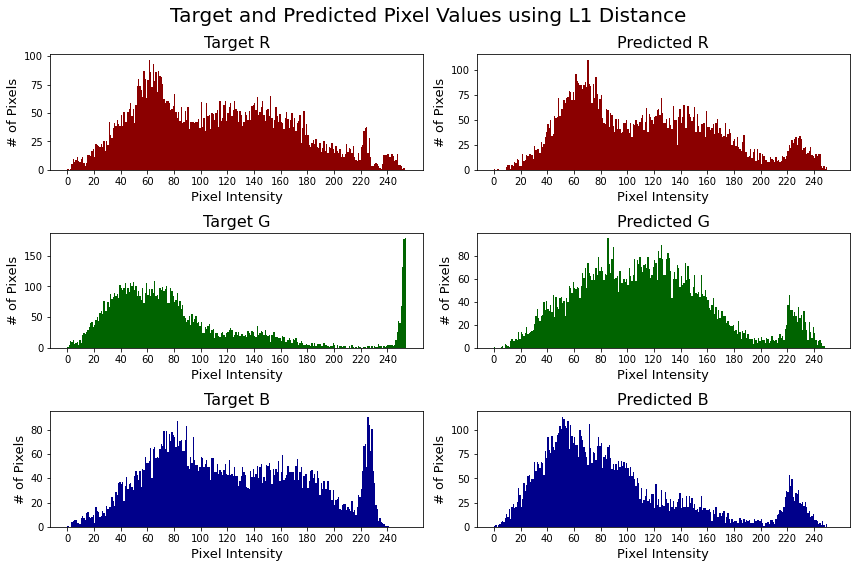

In [20]:
batch_size = 10
target = 'data/target.jpg'
rgb_db = rgb_data.copy()
img_db = img_data.copy()
duplicate=False

r,g,b = extract_rgb(target)
image, target_points, dist_points, batches, total_dist = construct_mosaic(batch_size, r, g, b, rgb_db, 'l1', duplicate, img_db)
image.save('data/mosaic_tests/target_norepeats_pb10_l1.jpg')
avg_dist = total_dist/len(batches)
print('Total Distance of all points: ' + str(total_dist))
print('Average Point Distance: ' + str(avg_dist))

filename='data/figures/target_L1_pb10_norepeats.png'
figure_title = 'Target and Predicted Pixel Values using L1 Distance'
parse_results(filename, figure_title, target_points, dist_points)

#### L2

Total Distance of all points: 158465.35210043588


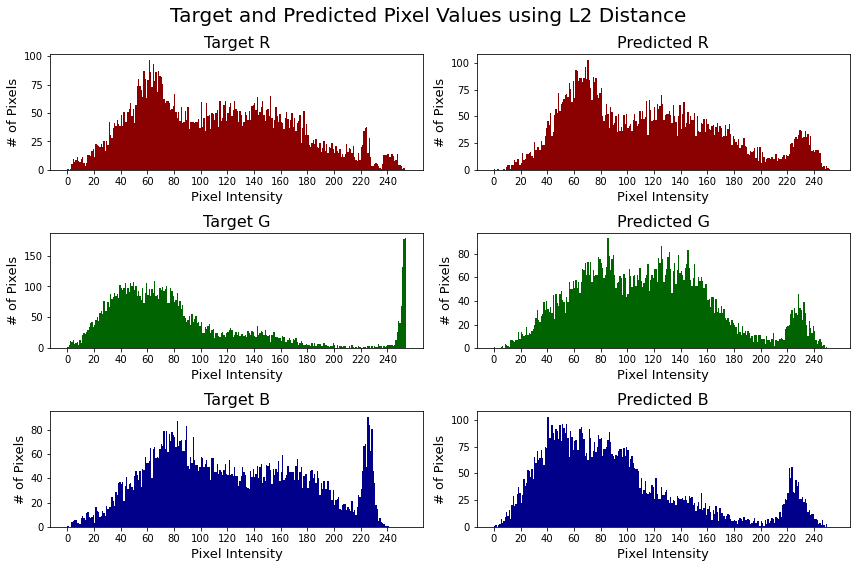

In [16]:
batch_size = 10
target = 'data/target.jpg'
rgb_db = rgb_data.copy()
img_db = img_data.copy()
duplicate=False

r,g,b = extract_rgb(target)
image, target_points, dist_points, batches, total_dist = construct_mosaic(pixel_batch, r, g, b, data, 'l2', duplicate, img_db)
image.save('data/mosaic_tests/target_norepeats_pb10_l2.jpg')
avg_dist = total_dist/len(batches)
print('Total Distance of all points: ' + str(total_dist))
print('Average Point Distance: ' + str(avg_dist))

filename='data/figures/L2_pb10_norepeats.png'
figure_title = 'Target and Predicted Pixel Values using L2 Distance'
parse_results(filename, figure_title, target_points, dist_points)

#### RMSE

Total Distance of all points: 112051.92505333236


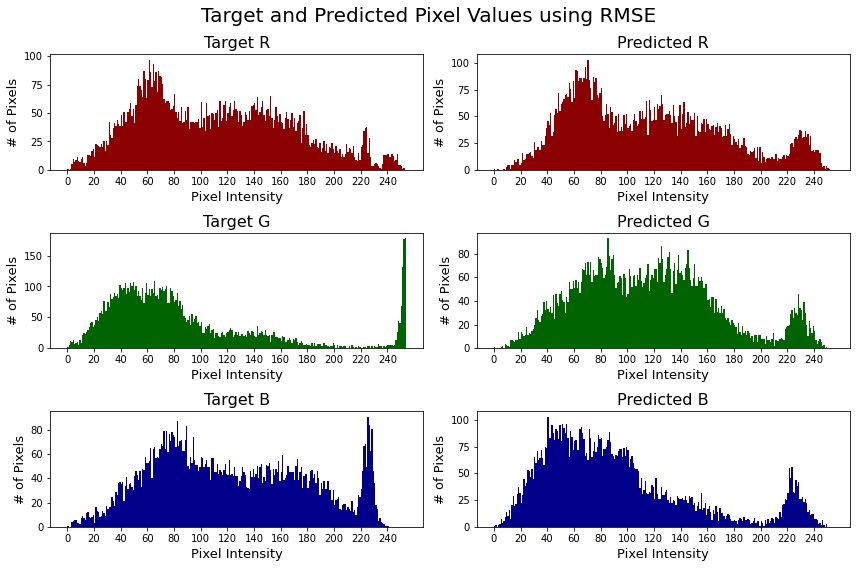

In [17]:
batch_size = 10
target = 'data/target.jpg'
rgb_db = rgb_data.copy()
img_db = img_data.copy()
duplicate=False

r,g,b = extract_rgb(target)
image, target_points, dist_points, batches, total_dist = construct_mosaic(pixel_batch, r, g, b, data, 'rmse', duplicate, img_db)
image.save('data/mosaic_tests/target_norepeats_pb10_rmse.jpg')
avg_dist = total_dist/len(batches)
print('Total Distance of all points: ' + str(total_dist))
print('Average Point Distance: ' + str(avg_dist))

filename='data/figures/rmse_pb10_norepeats.png'
figure_title = 'Target and Predicted Pixel Values using RMSE'
parse_results(filename, figure_title, target_points, dist_points)

### Repeats

#### L1

Total Distance of all points: 61794.63543657941


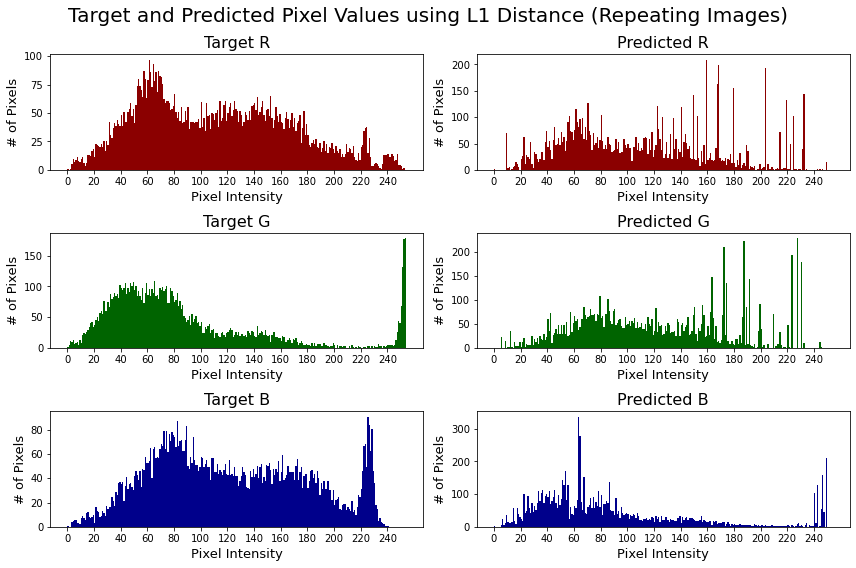

In [18]:
batch_size = 10
target = 'data/target.jpg'
rgb_db = rgb_data.copy()
img_db = img_data.copy()
duplicate=False

r,g,b = extract_rgb(target)
image, target_points, dist_points, batches, total_dist = construct_mosaic(pixel_batch, r, g, b, data, 'l1', duplicate, img_db)
image.save('data/mosaic_tests/target_repeats_pb10_l1.jpg')
avg_dist = total_dist/len(batches)
print('Total Distance of all points: ' + str(total_dist))
print('Average Point Distance: ' + str(avg_dist))

filename='data/figures/L1_pb10_repeats.png'
figure_title = 'Target and Predicted Pixel Values using L1 Distance (Repeating Images)'
parse_results(filename, figure_title, target_points, dist_points)

#### L2

Total Distance of all points: 43441.85967853838


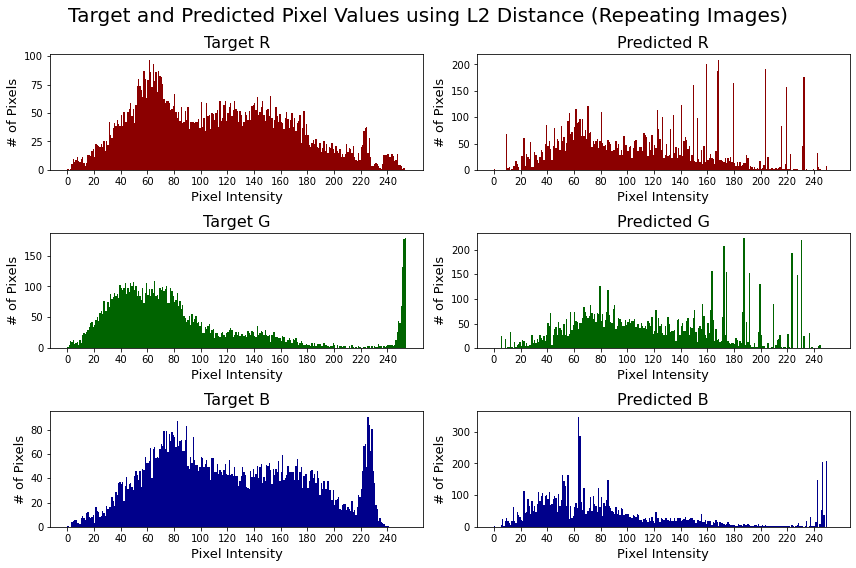

In [19]:
batch_size = 10
target = 'data/target.jpg'
rgb_db = rgb_data.copy()
img_db = img_data.copy()
duplicate=False

r,g,b = extract_rgb(target)
image, target_points, dist_points, batches, total_dist = construct_mosaic(pixel_batch, r, g, b, data, 'l2', duplicate, img_db)
image.save('data/mosaic_tests/target_repeats_pb10_l2.jpg')
avg_dist = total_dist/len(batches)
print('Total Distance of all points: ' + str(total_dist))
print('Average Point Distance: ' + str(avg_dist))

filename='data/figures/L2_pb10_repeats.png'
figure_title = 'Target and Predicted Pixel Values using L2 Distance (Repeating Images)'
parse_results(filename, figure_title, target_points, dist_points)

#### RMSE

Total Distance of all points: 30718.033566048725


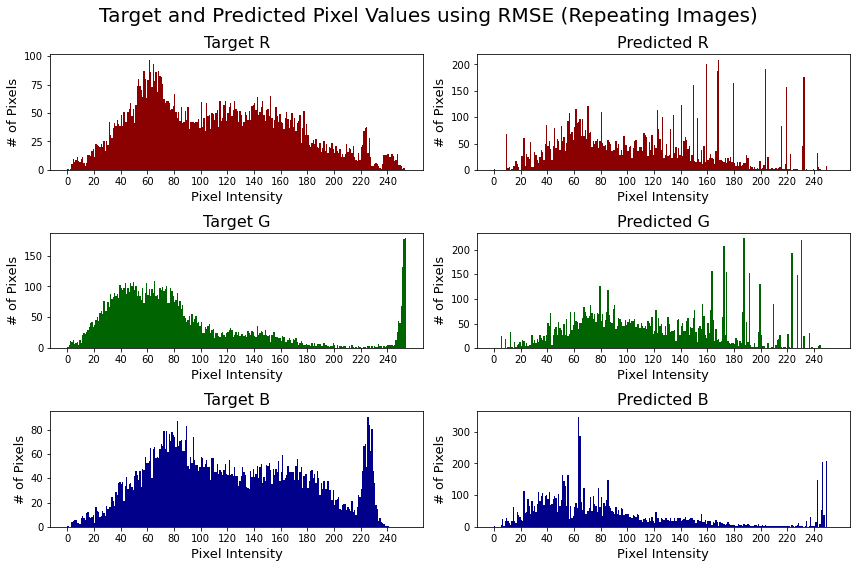

In [20]:
batch_size = 10
target = 'data/target.jpg'
rgb_db = rgb_data.copy()
img_db = img_data.copy()
duplicate=False

r,g,b = extract_rgb(target)
image, target_points, dist_points, batches, total_dist = construct_mosaic(pixel_batch, r, g, b, data, 'rmse', duplicate, img_db)
image.save('data/mosaic_tests/target_repeats_pb10_rmse.jpg')
avg_dist = total_dist/len(batches)
print('Total Distance of all points: ' + str(total_dist))
print('Average Point Distance: ' + str(avg_dist))

filename='data/figures/rmse_pb10_repeats.png'
figure_title = 'Target and Predicted Pixel Values using RMSE (Repeating Images)'
parse_results(filename, figure_title, target_points, dist_points)